In [166]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

### CONFIGURATION

In [112]:
FRAME_SIZE = 64
SEQUENCE_LENGTH = 16
data_dir = 'C:/Downloads/HAR'
print(os.listdir(data_dir))  

['bend', 'jack', 'jump', 'pjump', 'run', 'side', 'skip', 'walk', 'wave1', 'wave2']


###  STEP 1: LOAD & PREPROCESS DATA 

In [113]:
def extract_frames(video_path, sequence_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (FRAME_SIZE, FRAME_SIZE))
        frames.append(frame)
    cap.release()
    
    # Slice video into sequences of fixed length
    sequences = []
    for i in range(0, len(frames) - sequence_length + 1, sequence_length):
        seq = frames[i:i+sequence_length]
        sequences.append(np.array(seq))
    return sequences

X_data = []
y_data = []
action_labels = {}
label_counter = 0

for action_folder in os.listdir(data_dir):
    action_path = os.path.join(data_dir, action_folder)
    if os.path.isdir(action_path):
        if action_folder not in action_labels:
            action_labels[action_folder] = label_counter
            label_counter += 1

        for file in os.listdir(action_path):
            if file.endswith('.avi'):
                video_path = os.path.join(action_path, file)
                sequences = extract_frames(video_path)
                for seq in sequences:
                    X_data.append(seq)
                    y_data.append(action_labels[action_folder])

X_data = np.array(X_data)
y_data = np.array(y_data)
X_data = X_data / 255.0  # normalize

# Add channel dimension
X_data = X_data.reshape((-1, SEQUENCE_LENGTH, FRAME_SIZE, FRAME_SIZE, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

### STEP 2: BUILD MODEL (CNN + LSTM)


In [186]:
def build_model():
    model = models.Sequential()
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, FRAME_SIZE, FRAME_SIZE, 1)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(action_labels), activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_146                 │ (None, 16, 62, 62, 32)      │             320 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_147                 │ (None, 16, 31, 31, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_148                 │ (None, 16, 29, 29, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_149                 │ (None, 16, 14, 14, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_150                 │ (None, 16, 12544)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │       3,227,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,251,530 (12.40 MB)

 Trainable params: 3,251,530 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

### STEP 3: TRAIN & EVALUATION

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 709ms/step - accuracy: 0.0924 - loss: 2.3367 - val_accuracy: 0.1429 - val_loss: 2.2681
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 602ms/step - accuracy: 0.1626 - loss: 2.2925 - val_accuracy: 0.2381 - val_loss: 2.1781
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 606ms/step - accuracy: 0.1823 - loss: 2.1183 - val_accuracy: 0.3333 - val_loss: 1.9001
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.3761 - loss: 1.7391 - val_accuracy: 0.3810 - val_loss: 1.6173
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - accuracy: 0.3533 - loss: 1.5605 - val_accuracy: 0.3810 - val_loss: 1.5352
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.5285 - loss: 1.3078 - val_accuracy: 0.4762 - val_loss: 1.3893
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - accuracy: 0.5672 - loss: 1.1461 - val_accuracy: 0.4921 - val_loss: 1.2963
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 615ms/step - accuracy: 0.6493 - loss: 1.0347 - val_accu

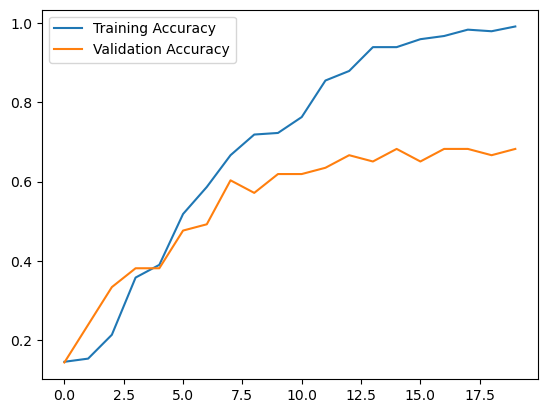

Label mapping: {'bend': 0, 'jack': 1, 'jump': 2, 'pjump': 3, 'run': 4, 'side': 5, 'skip': 6, 'walk': 7, 'wave1': 8, 'wave2': 9}


In [188]:
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

#Save model
model.save('weizmann_cnn_lstm_model.h5')

#Display label mapping 
print("Label mapping:", action_labels)

###  STEP 4: TEST ON A RANDOM FRAME SEQUENCE 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: walk
Actual: walk


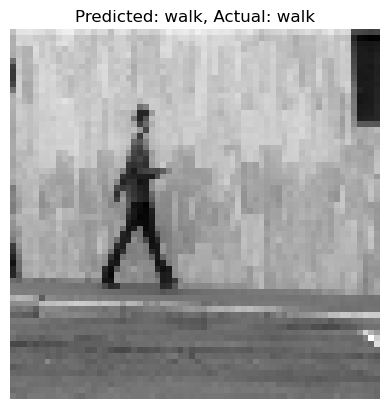

In [190]:
# Pick a random sample from test set
index = random.randint(0, len(X_test) - 1)
test_sequence = X_test[index]
actual_label = y_test[index]

# Add batch dimension for prediction
test_sequence_input = np.expand_dims(test_sequence, axis=0)

# Predict
prediction = model.predict(test_sequence_input)
predicted_label = np.argmax(prediction)

# Get label names
label_mapping_inverse = {v: k for k, v in action_labels.items()}

print(f"Predicted: {label_mapping_inverse[predicted_label]}")
print(f"Actual: {label_mapping_inverse[actual_label]}")

# Show one random frame from the selected sequence
frame_idx = random.randint(0, SEQUENCE_LENGTH - 1)
plt.imshow(test_sequence[frame_idx].squeeze(), cmap='gray')
plt.title(f"Predicted: {label_mapping_inverse[predicted_label]}, Actual: {label_mapping_inverse[actual_label]}")
plt.axis('off')
plt.show()

### Test on a video from weizmann dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


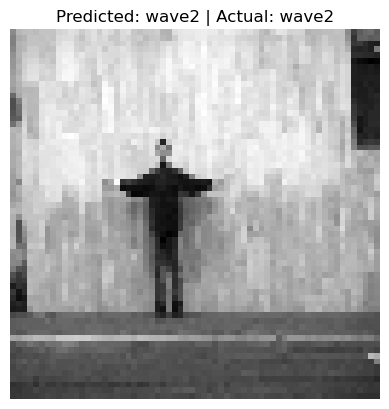

Predicted: wave2   |   Actual: wave2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


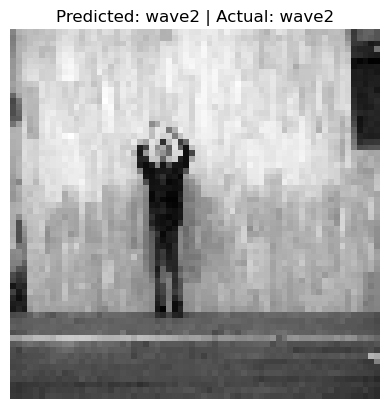

Predicted: wave2   |   Actual: wave2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


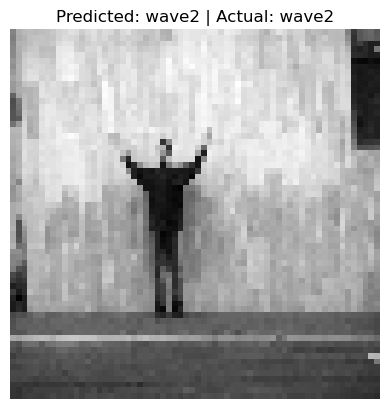

Predicted: wave2   |   Actual: wave2


In [184]:
# Load the trained model and action labels
model = load_model('weizmann_cnn_lstm_model.h5')
action_labels = {'bend':0, 'jack':1, 'jump':2, 'pjump':3, 'run':4, 'side':5, 'skip':6, 'walk':7, 'wave1':8, 'wave2':9}  
# ⚠ Replace with your actual label mapping if different
reverse_action_labels = {v: k for k, v in action_labels.items()}

FRAME_SIZE = 64
SEQUENCE_LENGTH = 16

def extract_frames_for_test(video_path, sequence_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (FRAME_SIZE, FRAME_SIZE))
        frames.append(frame)
    cap.release()
    
    sequences = []
    for i in range(0, len(frames) - sequence_length + 1, sequence_length):
        seq = frames[i:i+sequence_length]
        sequences.append(np.array(seq))
    return sequences

test_video_path = 'C:/Downloads/HAR/wave2/eli_wave2.avi'  
actual_label = os.path.basename(os.path.dirname(test_video_path))

sequences = extract_frames_for_test(test_video_path)

for seq in sequences:
    seq_normalized = seq / 255.0
    seq_normalized = seq_normalized.reshape(1, SEQUENCE_LENGTH, FRAME_SIZE, FRAME_SIZE, 1)
    prediction = model.predict(seq_normalized)
    predicted_label_index = np.argmax(prediction)
    predicted_label = reverse_action_labels[predicted_label_index]
    
    # Display one frame from the sequence (the first frame)
    plt.imshow(seq[0], cmap='gray')
    plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}")
    plt.axis('off')
    plt.show()
    
    print(f"Predicted: {predicted_label}   |   Actual: {actual_label}")


### Test on a random Youtube video https://youtu.be/6CSlxktGZOQ?si=9o2AlrFYunZLseFV

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


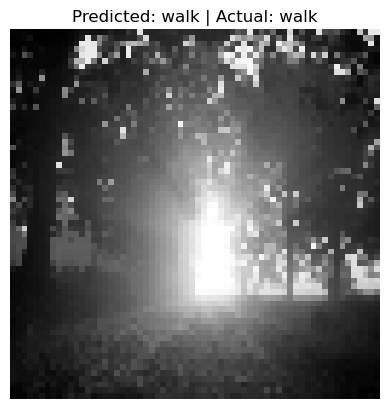

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


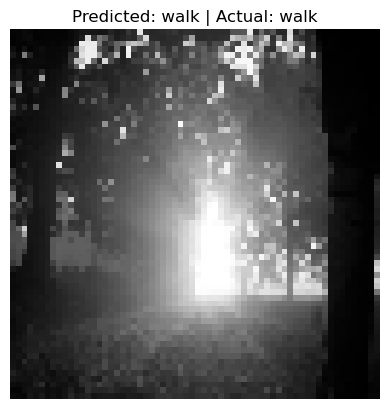

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


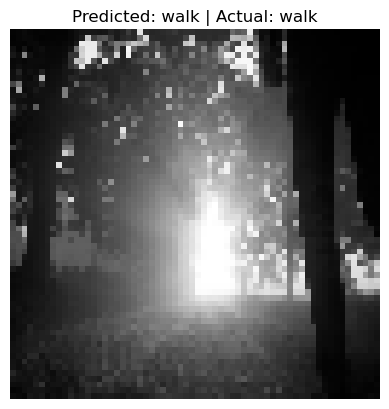

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


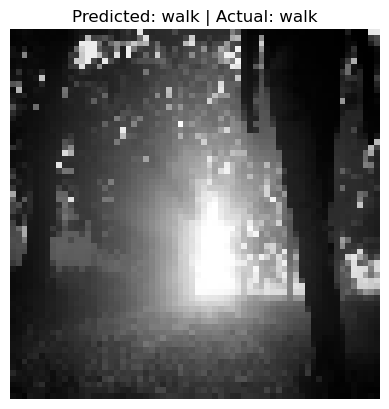

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


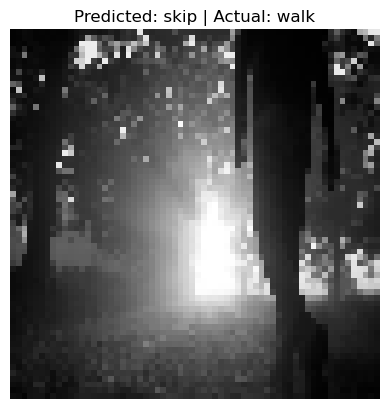

Predicted: skip   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


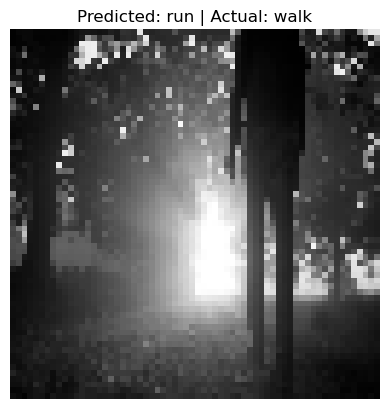

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


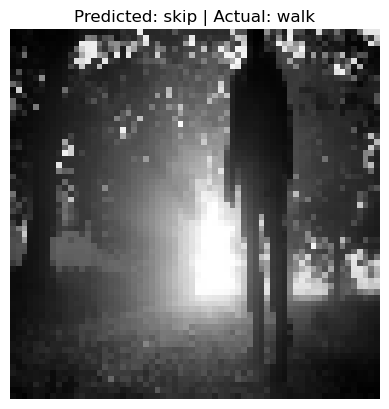

Predicted: skip   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


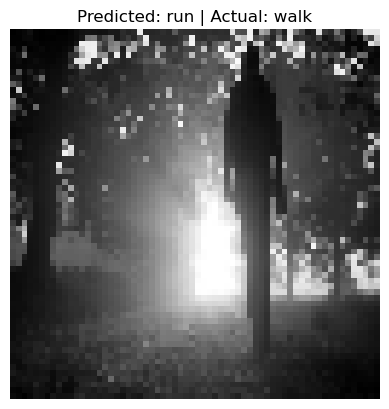

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


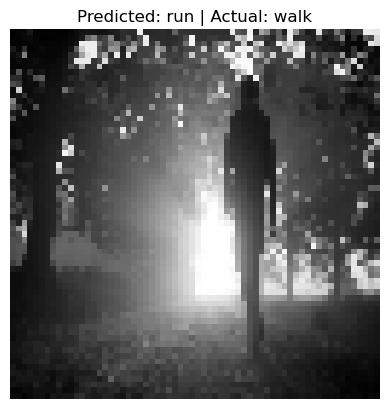

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


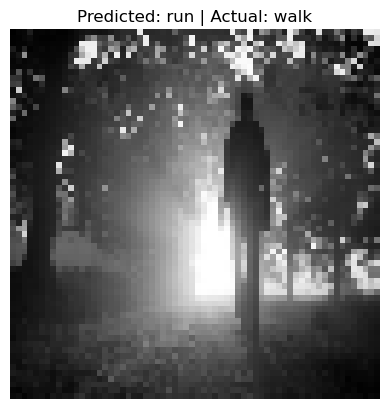

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


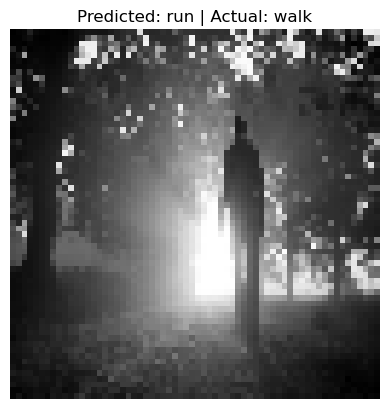

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


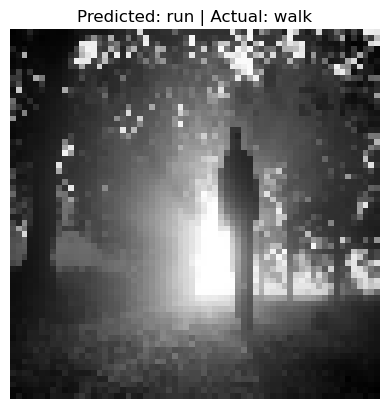

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


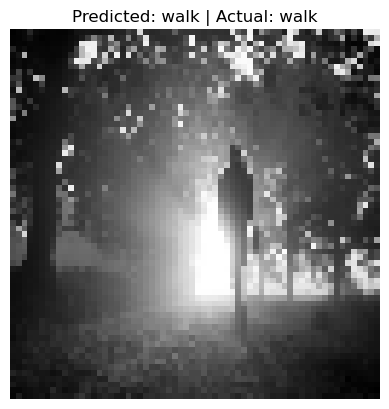

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


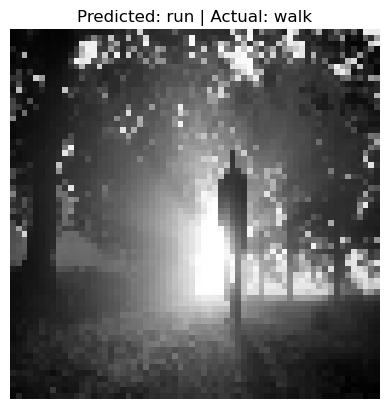

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


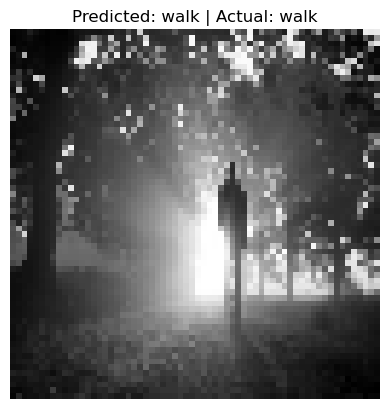

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


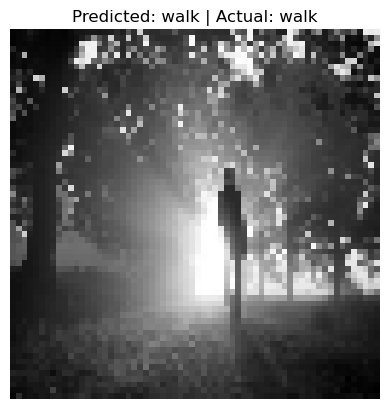

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


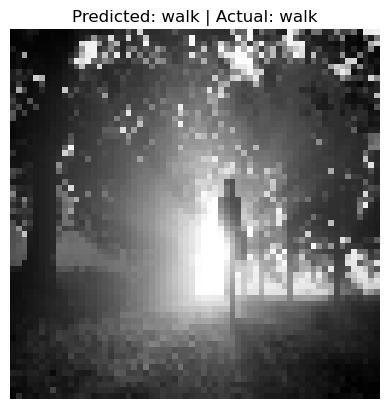

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


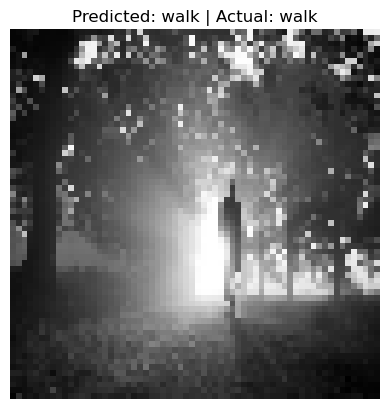

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


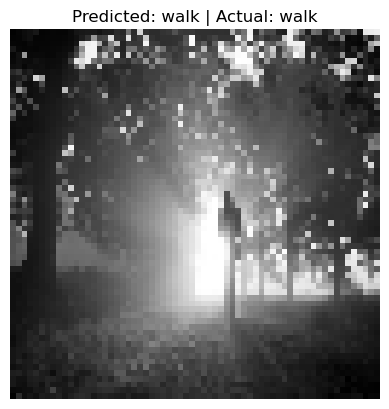

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


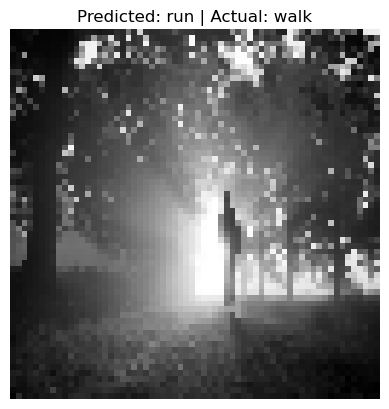

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


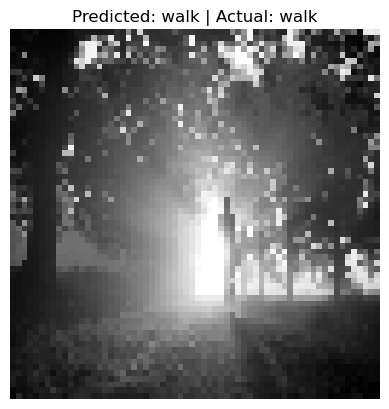

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


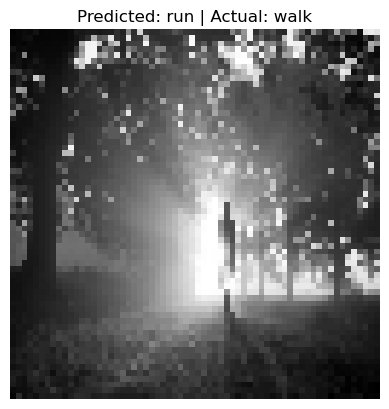

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


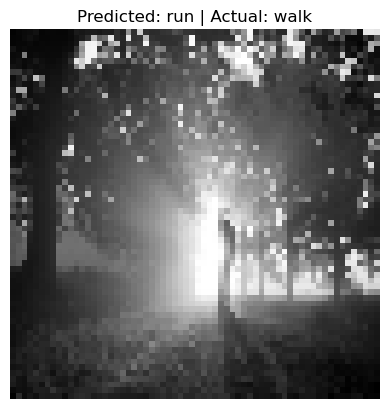

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


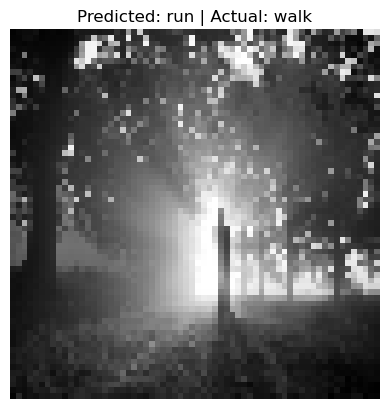

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


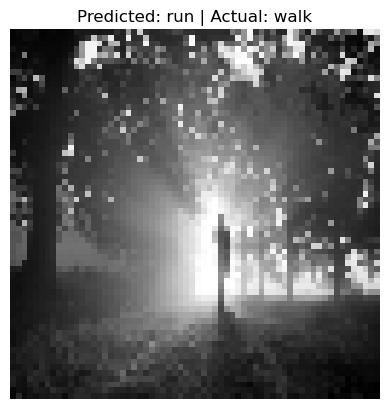

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


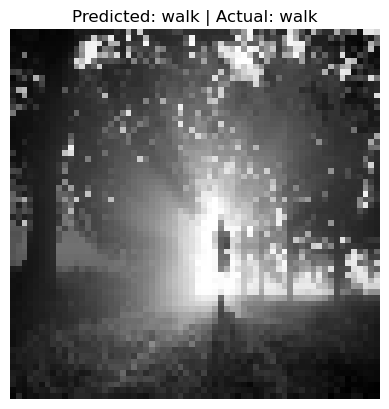

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


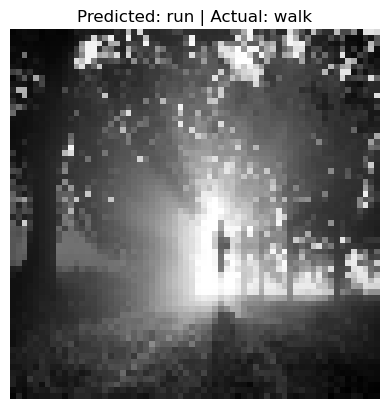

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


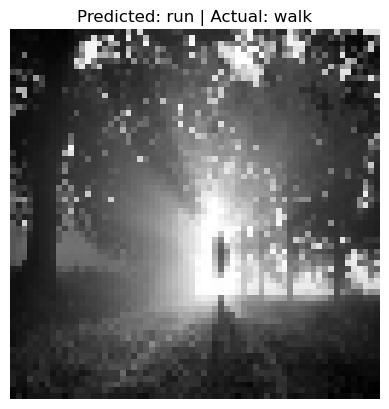

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


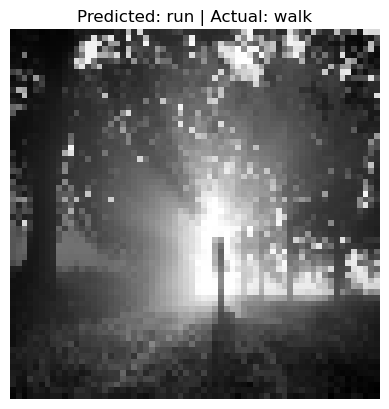

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


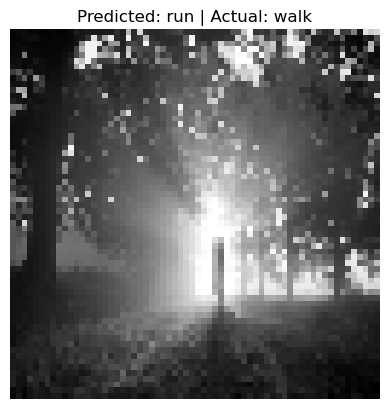

Predicted: run   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


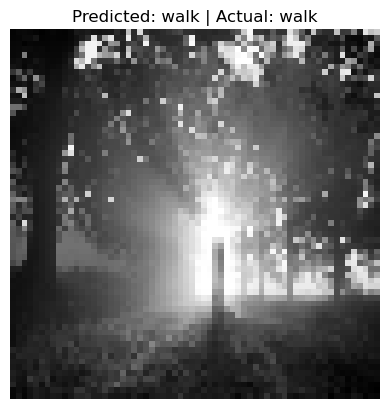

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


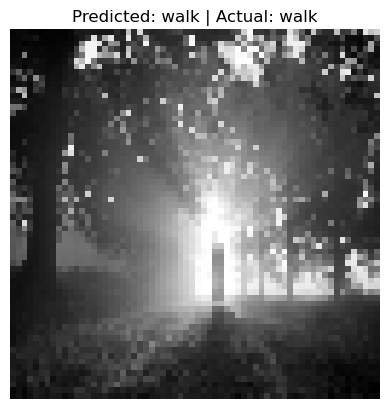

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


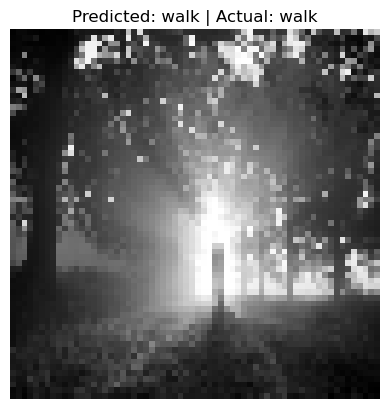

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


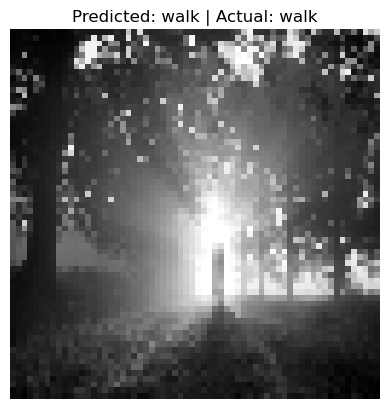

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


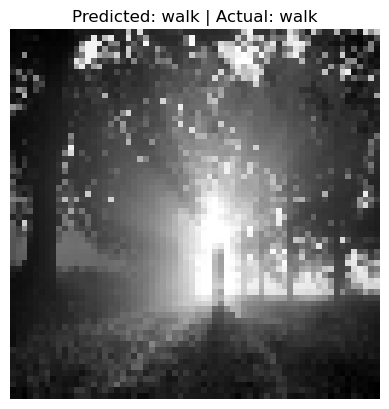

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


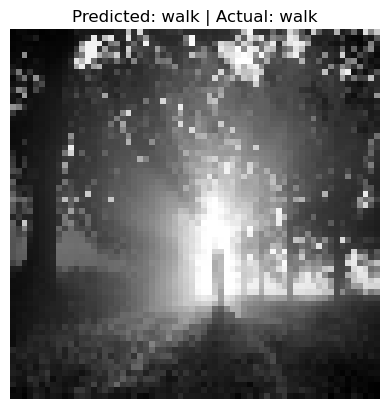

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


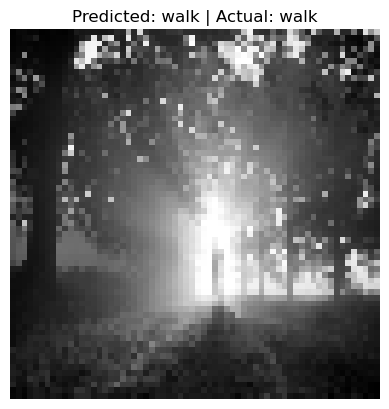

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


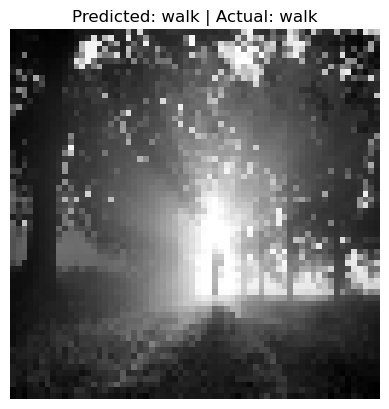

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


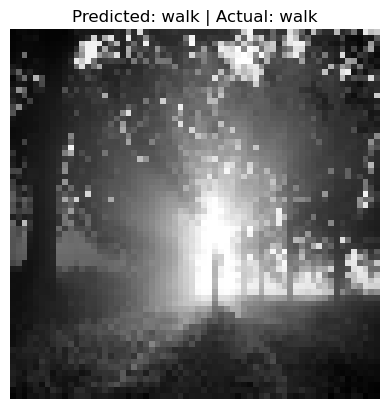

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


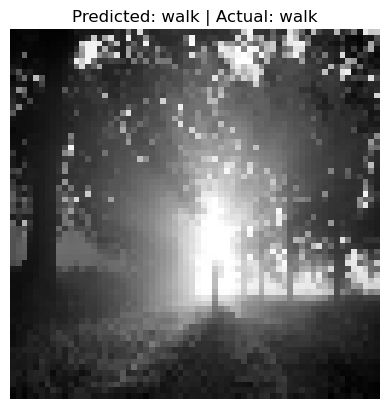

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


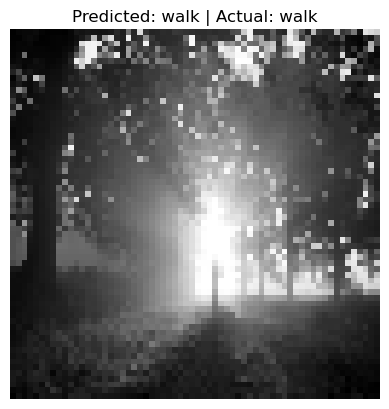

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


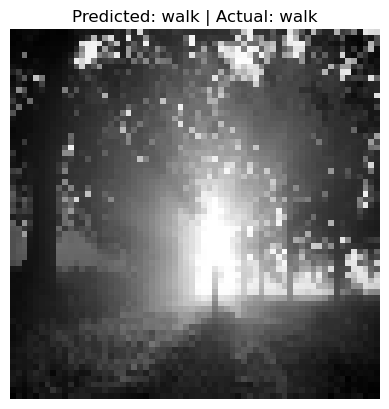

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


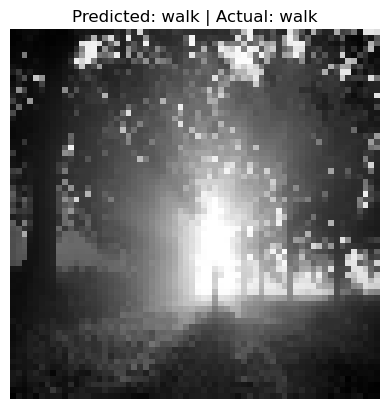

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


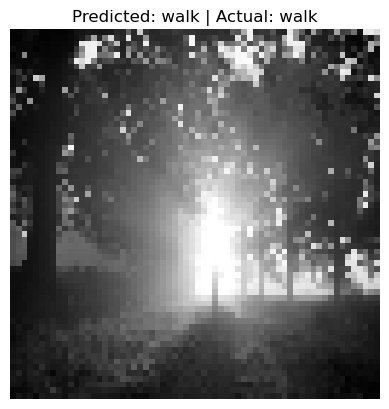

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


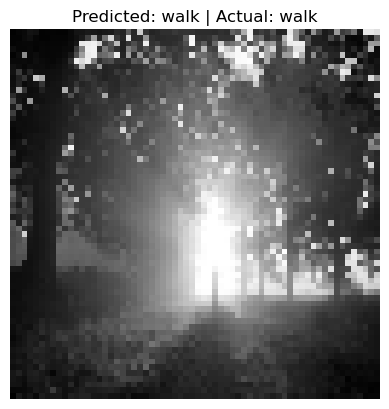

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


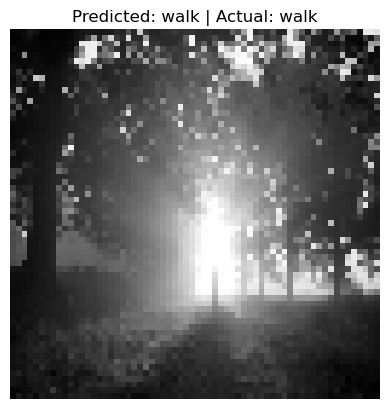

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


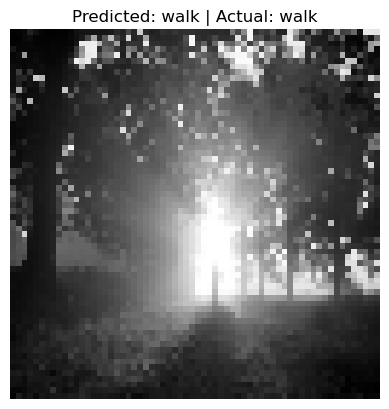

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


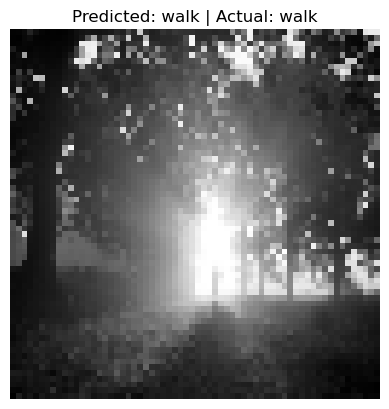

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


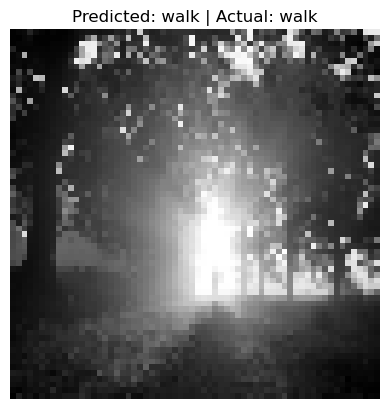

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


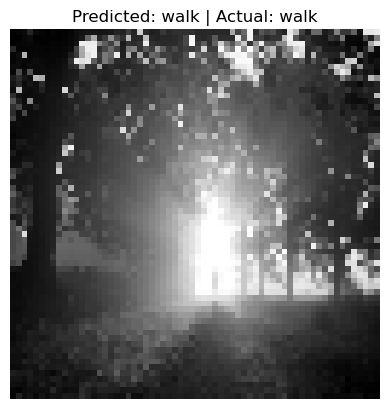

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


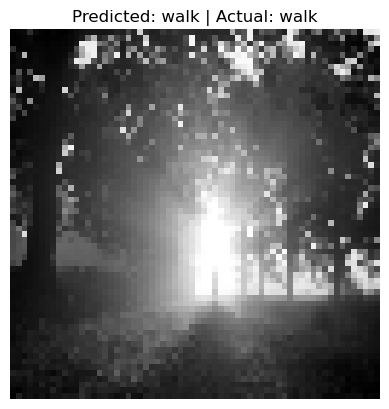

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


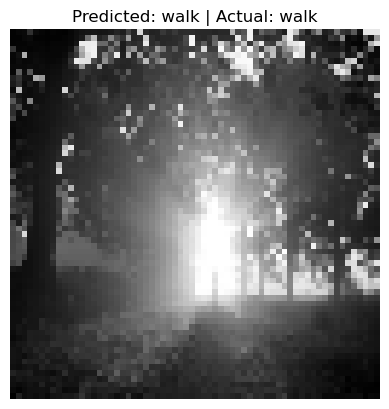

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


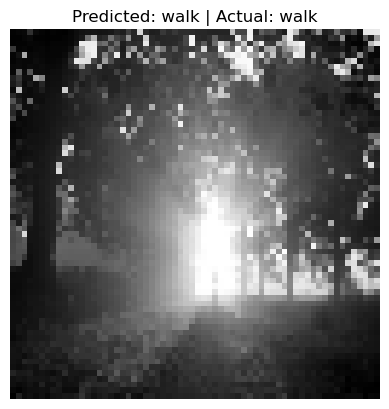

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


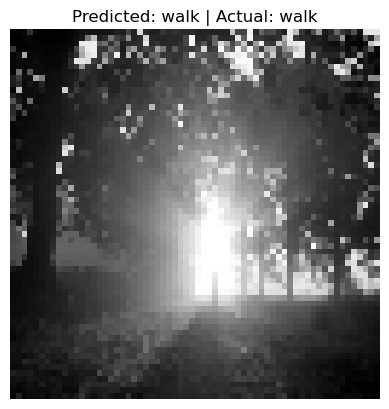

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


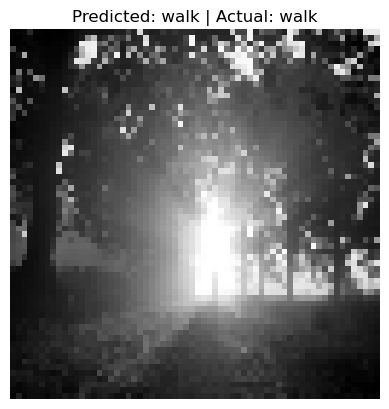

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


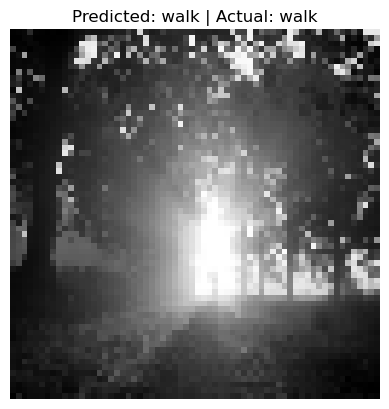

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


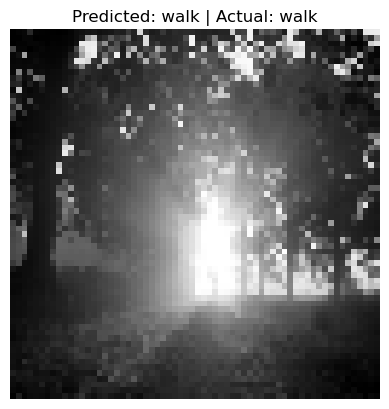

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


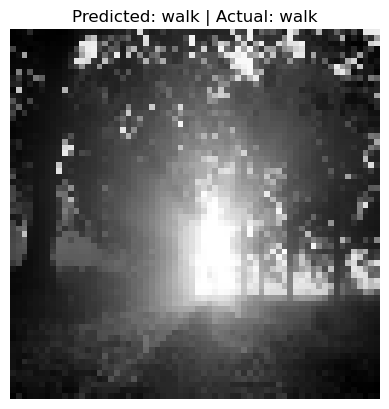

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


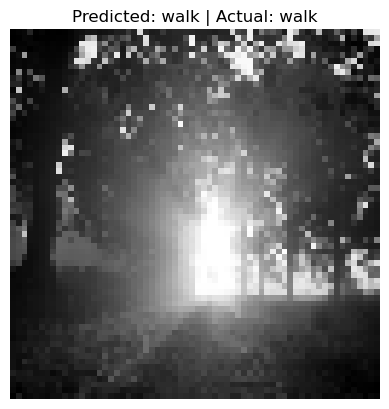

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


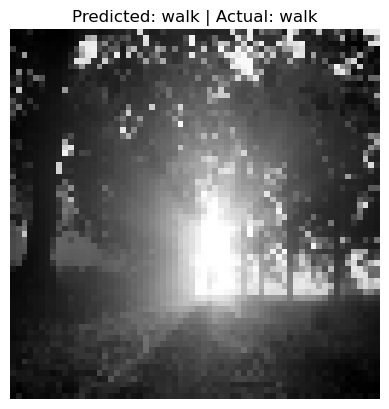

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


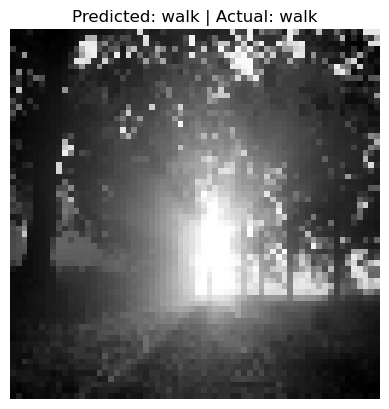

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


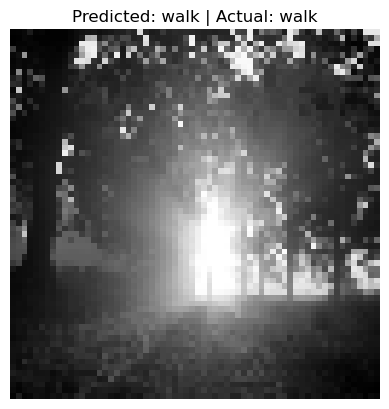

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


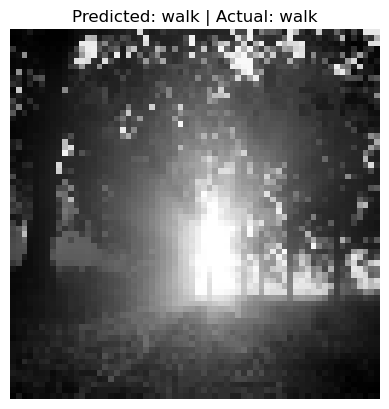

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


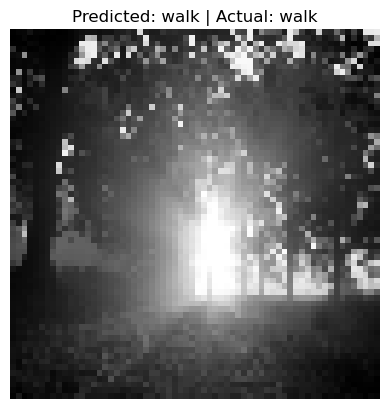

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


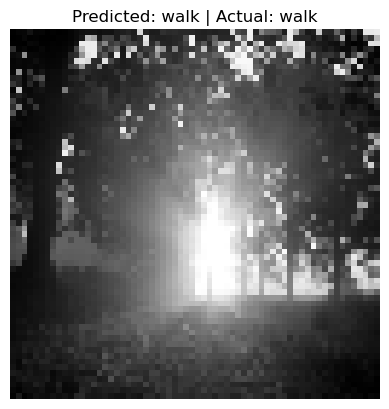

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


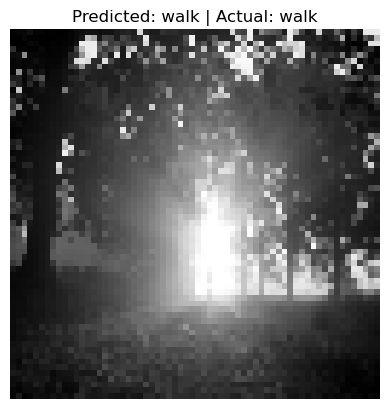

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


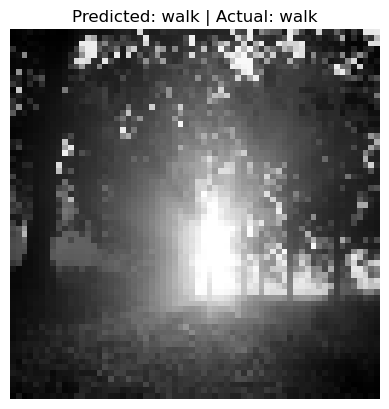

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


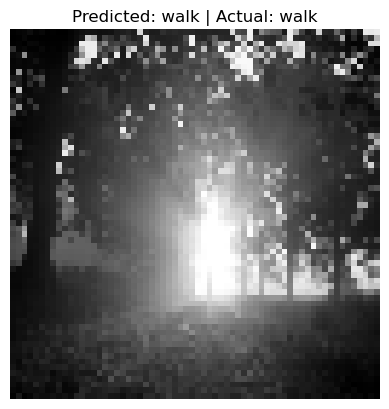

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


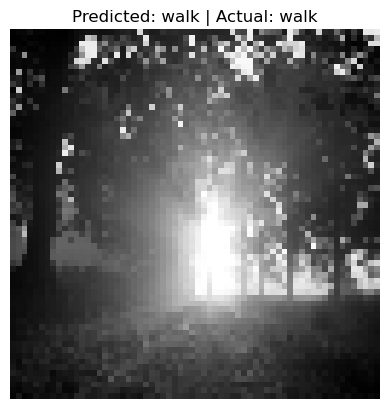

Predicted: walk   |   Actual: walk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


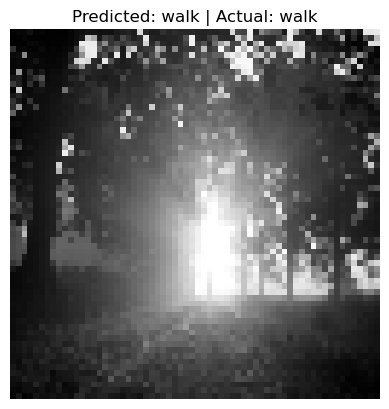

Predicted: walk   |   Actual: walk
 Prediction for the entire video: walk   |   Actual: walk


In [214]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from collections import Counter

# Load the trained model and action labels
model = load_model('weizmann_cnn_lstm_model.h5')
action_labels = {'bend':0, 'jack':1, 'jump':2, 'pjump':3, 'run':4, 'side':5, 'skip':6, 'walk':7, 'wave1':8, 'wave2':9}  
reverse_action_labels = {v: k for k, v in action_labels.items()}

FRAME_SIZE = 64
SEQUENCE_LENGTH = 16

def extract_frames_for_test(video_path, sequence_length=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (FRAME_SIZE, FRAME_SIZE))
        frames.append(frame)
    cap.release()
    
    sequences = []
    for i in range(0, len(frames) - sequence_length + 1, sequence_length):
        seq = frames[i:i+sequence_length]
        sequences.append(np.array(seq))
    return sequences

# Test on a new video
test_video_path = 'C:/Downloads/yu.avi'  
actual_label = 'walk'  
sequences = extract_frames_for_test(test_video_path)

predictions = []

for seq in sequences:
    seq_normalized = seq / 255.0
    seq_normalized = seq_normalized.reshape(1, SEQUENCE_LENGTH, FRAME_SIZE, FRAME_SIZE, 1)
    prediction = model.predict(seq_normalized)
    predicted_label_index = np.argmax(prediction)
    predicted_label = reverse_action_labels[predicted_label_index]
    predictions.append(predicted_label)
    
    # Display one frame from the sequence (the first frame)
    plt.imshow(seq[0], cmap='gray')
    plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}")
    plt.axis('off')
    plt.show()
    
    print(f"Predicted: {predicted_label}   |   Actual: {actual_label}")

# Determine the majority prediction
majority_label = Counter(predictions).most_common(1)[0][0]
print(f" Prediction for the entire video: {majority_label}   |   Actual: {actual_label}")
